# Car Racing


## ***Step 1:*** Install libraries

In [ ]:
# @title установка драйверов
!apt-get update > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get install -y swig build-essential python-dev python3-dev > /dev/null 2>&1
!apt-get install x11-utils > /dev/null 2>&1
!apt-get install xvfb > /dev/null 2>&1

In [ ]:
# @title установка библиотек
%%capture
!pip install rarfile --quiet
!pip install stable-baselines3[extra] --quiet
!pip install ale-py --quiet
!pip install gym[box2d] --quiet
!pip install pyvirtualdisplay --quiet
!pip install pyglet --quiet
!pip install pygame --quiet
!pip install minigrid --quiet
!pip install -q swig --quiet
!pip install -q gymnasium[box2d] --quiet
!pip install 'minigrid<=2.1.1' --quiet
!pip3 install box2d-py --quiet


## ***Step 2:*** Import useful libraries

In [ ]:
# Imports
import io
import os
import glob
import torch
import base64

import numpy as np
import matplotlib.pyplot as plt

import sys
import gymnasium
sys.modules["gym"] = gymnasium

import stable_baselines3
from stable_baselines3.common.results_plotter import ts2xy, load_results
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_atari_env

import gymnasium as gym
from gym import spaces
from gym.wrappers import RecordVideo

In [ ]:
# !git clone https://github.com/AGiannoutsos/car_racer_gym.git
# %cd car_racer_gym

# from car_racing import CarRacingDiscrete, CarRacing

In [ ]:
# @title Вспомогательная функция вывода в виртуальный дисплей
from IPython.display import HTML
from base64 import b64encode
from pyvirtualdisplay import Display

# create the directory to store the video(s)
os.makedirs("./video", exist_ok=True)

display = Display(visible=False, size=(1400, 900))
_ = display.start()

"""
Функция позволяет записывать видео из gym и отображать его.
Чтобы включить видео, просто выполните "env = wrap_env(env)""
"""
def render_mp4(videopath: str) -> str:
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

## ***Step 3:*** Create video


In [ ]:
import gymnasium as gym
env = gym.make(
    "CarRacing-v3"
)

In [ ]:
observation, info = env.reset()

for _ in range(1000):
    action = env.action_space.sample()  # agent policy that uses the observation and info
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        observation, info = env.reset()

env.close()
print(reward)

-0.10000000000000142


In [ ]:
nn_layers = [64, 64]  # Это конфигурация вашей нейронной сети. В настоящее время у нас есть два слоя, каждый из которых состоит из 64 нейронов.
                      # Если вам нужны три слоя по 64 нейрона в каждом, установите значение [64,64,64] и так далее.

learning_rate = 0.001   # Это размер шага, с которым выполняется градиентный спуск.
                       # Совет: Используйте меньшие размеры шага для более крупных сетей.

In [ ]:
from stable_baselines3 import PPO
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

env_name = 'CarRacing-v3'
env = gym.make(env_name)

env = stable_baselines3.common.monitor.Monitor(env, log_dir )

callback = EvalCallback(env, log_path=log_dir, deterministic=True)  # For evaluating the performance of the agent periodically and logging the results.
policy_kwargs = dict(activation_fn=torch.nn.ReLU,
                     net_arch=nn_layers)
model = PPO("CnnPolicy", env, policy_kwargs=policy_kwargs, verbose=0)# Set verbose to 1 to observe training logs. We encourage you to set the verbose to 1.


In [ ]:
env_name = 'CarRacing-v3'
env = gym.make(env_name)
print('Пространство наблюдений (состояний): ', env.observation_space.shape)
# print('Пространство действий:: ', env.action_space.n)

Пространство наблюдений (состояний):  (96, 96, 3)


In [ ]:
from tqdm import tqdm
env = gym.make(env_name, render_mode="rgb_array")
env = RecordVideo(env, video_folder=f"video/{env_name}_pretraining", episode_trigger=lambda episode_id: True)
observation = env.reset()[0]

total_reward = 0
done = False
for i in tqdm(range(500)):
  frame = env.render()
  action, states = model.predict(observation, deterministic=True)
  observation, reward, done, info, _ = env.step(action)
  total_reward += reward
env.close()
print(f"\nTotal reward: {total_reward}")

# show video
html = render_mp4(f"video/{env_name}_pretraining/rl-video-episode-0.mp4")
HTML(html)

/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/video/CarRacing-v3_pretraining folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
100%|██████████| 2000/2000 [01:18<00:00, 25.59it/s]



Total reward: -193.35548172756805


## ***Step 4:*** Create DPPG Algo

In [ ]:
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

latent_dim = 512

class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class Actor(nn.Module):
    def __init__(self, action_dim=3, img_stack=3):
        super(Actor, self).__init__()

        self.encoder = torch.nn.ModuleList([  ## input size:[96, 96]
            torch.nn.Conv2d(img_stack, 16, 5, 2, padding=2),  ## output size: [16, 48, 48]
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(16),
            torch.nn.Conv2d(16, 32, 5, 2, padding=2),  ## output size: [32, 24, 24]
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(32, 64, 5, 2, padding=2),  ## output size: [64, 12, 12]
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
            torch.nn.Conv2d(64, 128, 5, 4, padding=2),  ## output size: [128, 3, 3]
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(128),
            torch.nn.Conv2d(128, 256, 5, 2, padding=2),  ## output size: [256, 2, 2]
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(256),
            torch.nn.Conv2d(256, 512, 5, 2, padding=2),  ## output size: [512, 1, 1]
            Flatten(),  ## output: 512
        ])

        self.linear = torch.nn.ModuleList([
            torch.nn.Linear(latent_dim, 30),
            torch.nn.ReLU(),
            torch.nn.Linear(30, action_dim),
            torch.nn.Tanh(),
        ])

    def forward(self, x):

        # i = 0
        for layer in self.encoder:
            x = layer(x)
            # print((x, i))
            # i+=1
        # print(x.size())
        for layer in self.linear:
            x = layer(x)
            # print((x, i))
            # i+=1
            # print(x.size())

        return x

actor_origin_model = Actor().to(device)  # Q_phi
actor_target_model = Actor().to(device)  # Q_phi'
_ = actor_target_model.requires_grad_(False)  # target model doen't need grad

In [ ]:
class Critic(nn.Module):
    def __init__(self, action_dim=3, img_stack=3):
        super(Critic, self).__init__()

        self.encoder = torch.nn.ModuleList([  ## input size:[96, 96]
            torch.nn.Conv2d(img_stack, 16, 5, 2, padding=2),  ## output size: [16, 48, 48]
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(16),
            torch.nn.Conv2d(16, 32, 5, 2, padding=2),  ## output size: [32, 24, 24]
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(32, 64, 5, 2, padding=2),  ## output size: [64, 12, 12]
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
            torch.nn.Conv2d(64, 128, 5, 4, padding=2),  ## output size: [128, 3, 3]
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(128),
            torch.nn.Conv2d(128, 256, 5, 2, padding=2),  ## output size: [256, 2, 2]
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(256),
            torch.nn.Conv2d(256, 512, 5, 2, padding=2),  ## output size: [512, 1, 1]
            Flatten(),  ## output: 512
        ])

        self.linear = torch.nn.ModuleList([
            torch.nn.Linear(latent_dim + action_dim, 30),
            torch.nn.ReLU(),
            torch.nn.Linear(30, 1),
        ])

    def forward(self, x, u):
        # print(f"X shape in {x.shape}")
        # print(f'U shape is {u.shape}')
        for layer in self.encoder:
            x = layer(x)
        counter = 0
        for layer in self.linear:
            counter += 1
            if counter == 1:
                # print(f"X shape in layer: {x.shape}")
                # print(f'U shape in layer: {u.shape}')
                x = torch.cat([x, u], 1)
                x = layer(x)
            else:
                x = layer(x)

        return x

critic_origin_model = Critic().to(device)  # mu_theta
critic_target_model = Critic().to(device)  # mu_theta'

In [ ]:
from torch.nn import functional as F

from tqdm import tqdm

gamma = 0.99
actor_optimizer = torch.optim.AdamW(actor_origin_model.parameters(), lr=0.0005)
critic_optimizer = torch.optim.AdamW(critic_origin_model.parameters(), lr=0.0005)

def optimize(states, actions, rewards, next_states, dones):
    # Convert to tensor
    states = torch.tensor(states, dtype=torch.float).to(device)
    # print(f"States: {states.shape}")
    actions = torch.tensor(actions, dtype=torch.float).to(device)
    # actions = actions.unsqueeze(dim=1)
    rewards = torch.tensor(rewards, dtype=torch.float).to(device)
    rewards = rewards.unsqueeze(dim=1)
    next_states = torch.tensor(next_states, dtype=torch.float).to(device)
    next_states = next_states.permute(0,3,1,2)
    dones = torch.tensor(dones, dtype=torch.float).to(device)
    dones = dones.unsqueeze(dim=1)

    # Optimize critic loss


    critic_optimizer.zero_grad()

    # print(actor_target_model(next_states).shape)
    # print(next_states.shape)
    target_Q = critic_target_model(next_states, actor_target_model(next_states))
    target_Q = rewards + gamma * (1.0 - dones) * target_Q

    # print(f"Actor target model:{actor_target_model(next_states).shape}")
    # print(f"Next states: {next_states.shape}")

    # print("----------------")

    # print(f"Actions: {actions.shape}")
    # print(f"States: {states.shape}")

    current_Q = critic_origin_model(states, actions)

    critic_loss = F.mse_loss(
        target_Q,
        current_Q,
        reduction="none")

    critic_loss.sum().backward()
    critic_optimizer.step()

    # Optimize actor loss

    actor_optimizer.zero_grad()

    actor_loss = -critic_origin_model(states, actor_origin_model(states))
    actor_loss.sum().backward()
    actor_optimizer.step()

    # Define target gradient

    for p in critic_origin_model.parameters():
        p.requires_grad = True # disable grad in critic_origin_model before computation
    for p in actor_origin_model.parameters():
        p.requires_grad = True # enable grad again

In [ ]:
tau = 0.002

def update_target():
    for var, var_target in zip(actor_origin_model.parameters(), actor_target_model.parameters()):
        var_target.data = tau * var.data + (1.0 - tau) * var_target.data

    for var, var_target in zip(critic_origin_model.parameters(), critic_target_model.parameters()):
        var_target.data = tau * var.data + (1.0 - tau) * var_target.data

In [ ]:
import random
class replayBuffer:
    def __init__(self, buffer_size: int):
        self.buffer_size = buffer_size
        self.buffer = []
        self._next_idx = 0

    def add(self, item):
        if len(self.buffer) > self._next_idx:
            self.buffer[self._next_idx] = item
        else:
            self.buffer.append(item)
        if self._next_idx == self.buffer_size - 1:
            self._next_idx = 0
        else:
            self._next_idx = self._next_idx + 1

    def sample(self, batch_size):
        indices = [random.randint(0, len(self.buffer) - 1) for _ in range(batch_size)]
        states   = [self.buffer[i][0].transpose(2,0,1) for i in indices]
        actions  = [self.buffer[i][1] for i in indices]
        rewards  = [self.buffer[i][2] for i in indices]
        n_states = [self.buffer[i][3] for i in indices]
        dones    = [self.buffer[i][4] for i in indices]
        return states, actions, rewards, n_states, dones

    def length(self):
        return len(self.buffer)

## ***Step 5:*** OU noise

In [ ]:
"""
Ornstein-Uhlenbeck noise implemented by OpenAI
Copied from https://github.com/openai/baselines/blob/master/baselines/ddpg/noise.py
"""
class OrnsteinUhlenbeckActionNoise:
    def __init__(self, mu, sigma, theta=.15, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
            self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

ou_action_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(1), sigma=np.ones(1) * 0.05)


In [ ]:
# pick up action with Ornstein-Uhlenbeck noise
def pick_sample(s):
    with torch.no_grad():
        # s = np.array(s)
        s_batch = np.expand_dims(s, axis=0)
        # print(s_batch.shape)
        s_batch = torch.tensor(s_batch, dtype=torch.float).to(device)
        s_batch = s_batch.permute(0,3,1,2)
        # print(s_batch.shape)
        action_det = actor_origin_model(s_batch)
        action_det = action_det.squeeze(dim=1)
        noise = ou_action_noise()
        action = action_det.cpu().numpy() + noise
        # action = np.clip(action, -1.0, 1.0)
        return action.squeeze()
        # return np.array([float(action.item())])

In [ ]:
# Save model
import torch
from concurrent.futures import ThreadPoolExecutor

def save_model_async(model, filepath):
    """
    Асинхронное сохранение модели.
    """
    def save():
        torch.save(model.state_dict(), filepath)
        print(f"Model saved at {filepath}")

    executor = ThreadPoolExecutor(max_workers=1)
    executor.submit(save)

## ***Step 6:*** Main loop

In [ ]:
batch_size = 250

buffer = replayBuffer(buffer_size=20000)

reward_records = []

episodes = 200

maxtime = 250

for episode in tqdm(range(episodes)):
    # Run episode till done
    s = env.reset()[0]
    done = False
    cum_reward = 0
    best_reward = -int(1e8)
    for i in tqdm(range(maxtime),desc = "Timesteps"):
        a = pick_sample(s)
        # print(a)
        a.clip(env.action_space.low, env.action_space.high)
        s_next, r, done, truncate, _ = env.step(a)
        done = done or truncate
        buffer.add([s, a, r, s_next, float(done)])
        cum_reward += r

        # Train (optimize parameters)
        if buffer.length() >= batch_size:
            states, actions, rewards, n_states, dones = buffer.sample(batch_size)
            # print(f"Print states shape {len(states)}; state shape: {states[0].shape}\n")
            # print(f"Print actions shape {len(actions)}; state shape: {actions[0].shape}")
            optimize(states, actions, rewards, n_states, dones)
            update_target()
        s = s_next
    if cum_reward > best_reward:
        best_reward = cum_reward
        save_model_async(actor_origin_model, f"/content/drive/MyDrive/RL_dppg/best_actor_model_{i}.pth")
        save_model_async(actor_target_model, f"/content/drive/MyDrive/RL_dppg/best_actor_target_{i}.pth")
        save_model_async(actor_origin_model, f"/content/drive/MyDrive/RL_dppg/best_critic_model_{i}.pth")
        save_model_async(actor_target_model, f"/content/drive/MyDrive/RL_dppg/best_critic_target_{i}.pth")

    # Output total rewards in episode (max 500)
    # print("Run episode{} with rewards {}".format(i, cum_reward), end="\r")
    reward_records.append(cum_reward)

    # stop if reward mean > 475.0
    if np.average(reward_records[-50:]) > 475.0:
        break

print("\nDone")

Timesteps:   0%|          | 0/250 [00:00<?, ?it/s]

Model saved at /content/drive/MyDrive/RL_dppg/best_critic_model_249.pth
Model saved at /content/drive/MyDrive/RL_dppg/best_critic_target_249.pth
Model saved at /content/drive/MyDrive/RL_dppg/best_actor_target_249.pth
Model saved at /content/drive/MyDrive/RL_dppg/best_actor_model_249.pth



Timesteps:   0%|          | 0/250 [00:00<?, ?it/s]

Model saved at /content/drive/MyDrive/RL_dppg/best_actor_target_249.pth
Model saved at /content/drive/MyDrive/RL_dppg/best_critic_target_249.pth
Model saved at /content/drive/MyDrive/RL_dppg/best_critic_model_249.pth
Model saved at /content/drive/MyDrive/RL_dppg/best_actor_model_249.pth



Timesteps:   0%|          | 0/250 [00:00<?, ?it/s]

Model saved at /content/drive/MyDrive/RL_dppg/best_actor_model_249.pth
Model saved at /content/drive/MyDrive/RL_dppg/best_actor_target_249.pth
Model saved at /content/drive/MyDrive/RL_dppg/best_critic_model_249.pth



Timesteps:   0%|          | 1/250 [00:06<27:02,  6.52s/it]

Model saved at /content/drive/MyDrive/RL_dppg/best_critic_target_249.pth



Timesteps:   0%|          | 0/250 [00:00<?, ?it/s]

Model saved at /content/drive/MyDrive/RL_dppg/best_actor_target_249.pth



Timesteps:   0%|          | 1/250 [00:06<27:02,  6.52s/it]

Model saved at /content/drive/MyDrive/RL_dppg/best_actor_model_249.pthModel saved at /content/drive/MyDrive/RL_dppg/best_critic_model_249.pth

Model saved at /content/drive/MyDrive/RL_dppg/best_critic_target_249.pth



  2%|▎         | 5/200 [1:35:38<70:44:31, 1306.01s/it]

Model saved at /content/drive/MyDrive/RL_dppg/best_actor_model_249.pth



Timesteps:   0%|          | 0/250 [00:00<?, ?it/s]

Model saved at /content/drive/MyDrive/RL_dppg/best_actor_target_249.pth
Model saved at /content/drive/MyDrive/RL_dppg/best_critic_target_249.pth
Model saved at /content/drive/MyDrive/RL_dppg/best_critic_model_249.pth



Timesteps:   0%|          | 0/250 [00:00<?, ?it/s]

Model saved at /content/drive/MyDrive/RL_dppg/best_critic_target_249.pth
Model saved at /content/drive/MyDrive/RL_dppg/best_actor_target_249.pth
Model saved at /content/drive/MyDrive/RL_dppg/best_actor_model_249.pth
Model saved at /content/drive/MyDrive/RL_dppg/best_critic_model_249.pth



  3%|▎         | 6/200 [1:59:29<64:23:41, 1194.96s/it]


KeyboardInterrupt: 

In [ ]:
from tqdm import tqdm
env = gym.make(env_name, render_mode="rgb_array")
env = RecordVideo(env, video_folder=f"video/{env_name}_pretraining", episode_trigger=lambda episode_id: True)
observation = env.reset()[0]

total_reward = 0
done = False
for i in tqdm(range(500)):
  frame = env.render()
  observation = torch.tensor(observation, dtype=torch.float).to(device)
  observation = observation.unsqueeze(0)
  observation = observation.permute(0,3,1,2)
  action = actor_origin_model(observation)
  observation, reward, done, info, _ = env.step(action.detach().cpu().numpy().squeeze())
  total_reward += reward
env.close()
print(f"\nTotal reward: {total_reward}")

# show video
html = render_mp4(f"video/{env_name}_pretraining/rl-video-episode-0.mp4")
HTML(html)

In [ ]:
html = render_mp4(f"video/{env_name}_pretraining/rl-video-episode-0.mp4")
HTML(html)

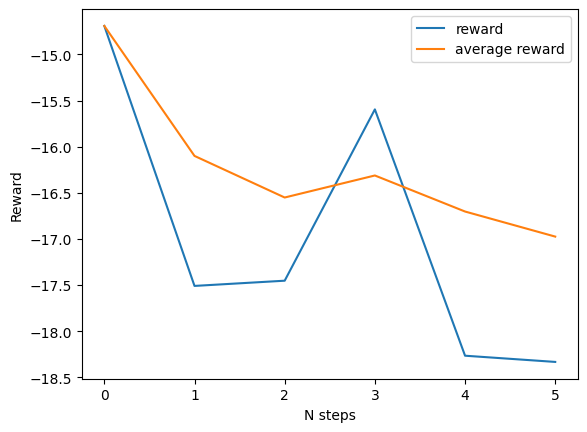

In [110]:
import matplotlib.pyplot as plt
# Generate recent 50 interval average
reward_recors = [-14.690721649484491,
 -17.509363295880124,
 -17.452830188679215,
 -15.595611285266413,
 -18.265993265993252,
 -18.33333333333332]
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 50:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-49:idx+1]
    average_reward.append(np.average(avg_list))
plt.plot(reward_records, label='reward')
plt.plot(average_reward, label='average reward')
plt.xlabel('N steps')
plt.ylabel('Reward')
plt.legend()
plt.show()